## Loading a csv file in Pandas
The capital_onebike.csv file covers the October, November and December rides of the Capital Bikeshare bike W20529.

Here are the first two columns:

Start date	End date	... <br>
2017-10-01 15:23:25	2017-10-01 15:26:26	...<br>
2017-10-01 15:42:57	2017-10-01 17:49:59	...<br>


In [14]:
# Import pandas
import pandas as pd

# Load CSV into the rides variable
rides = pd.read_csv('capital-onebike.csv', 
                    parse_dates = ["start", "end"])

# Print the initial (0th) row
print(rides.iloc[0])

start                             2017-10-01 15:23:25
end                               2017-10-01 15:26:26
Start station number                            31038
Start station                    Glebe Rd & 11th St N
End station number                              31036
End station             George Mason Dr & Wilson Blvd
Bike number                                    W20529
Member type                                    Member
Name: 0, dtype: object


Geat! Did you know that pandas has a pd.read_excel(), pd.read_json(), and even a pd.read_clipboard() function to read tabular data that you've copied from a document or website? Most have date parsing functionality too.

#### Making timedelta columns
Earlier in this course, you wrote a loop to subtract datetime objects and determine how long our sample bike had been out of the docks. Now you'll do the same thing with Pandas.

rides has already been loaded for you.

In [15]:
# Subtract the start date from the end date
ride_durations = rides["end"] - rides["start"]

# Convert the results to seconds
rides["Duration"] = ride_durations.dt.total_seconds()

print(rides['Duration'].head())

0     181.0
1    7622.0
2     343.0
3    1278.0
4    1277.0
Name: Duration, dtype: float64


Great! Because Pandas supports method chaining, you could also perform this operation in one line: rides['Duration'] = (rides['End date'] - rides['Start date']).dt.total_seconds()

## Summarizing datetime data in Pandas

#### How many joyrides?
Suppose you have a theory that some people take long bike rides before putting their bike back in the same dock. Let's call these rides "joyrides".

You only have data on one bike, so while you can't draw any bigger conclusions, it's certainly worth a look.

Are there many joyrides? How long were they in our data set? Use the median instead of the mean, because we know there are some very long trips in our data set that might skew the answer, and the median is less sensitive to outliers.

In [16]:
# Create joyrides
joyrides = (rides["Start station"] == rides["End station"])

# Total number of joyrides
print("{} rides were joyrides".format(joyrides.sum()))

# Median of all rides
print("The median duration overall was {:.2f} seconds"\
      .format(rides['Duration'].median()))

# Median of joyrides
print("The median duration for joyrides was {:.2f} seconds"\
      .format(rides[joyrides]['Duration'].median()))

6 rides were joyrides
The median duration overall was 660.00 seconds
The median duration for joyrides was 2642.50 seconds


Great work! Pandas makes analyses like these concise to write and reason about. Writing this as a for loop would have been more complex.

#### It's getting cold outside, W20529
Washington, D.C. has mild weather overall, but the average high temperature in October (68ºF / 20ºC) is certainly higher than the average high temperature in December (47ºF / 8ºC). People also travel more in December, and they work fewer days so they commute less.

How might the weather or the season have affected the length of bike trips?

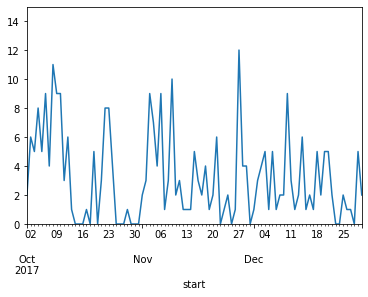

In [17]:
# Import matplotlib
import matplotlib.pyplot as plt

# Resample rides to daily, take the size, plot the results
rides.resample("D", on = 'start')\
  .size()\
  .plot(ylim = [0, 15])

# Show the results
plt.show()

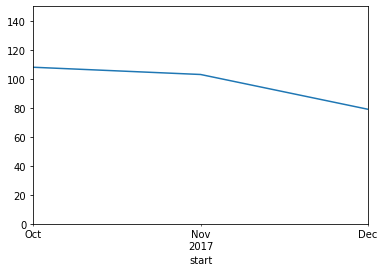

In [18]:
# Import matplotlib
import matplotlib.pyplot as plt

# Resample rides to monthly, take the size, plot the results
rides.resample("M", on = 'start')\
  .size()\
  .plot(ylim = [0, 150])

# Show the results
plt.show()

Nice! As you can see, the pattern is clearer at the monthly level: there were fewer rides in November, and then fewer still in December, possibly because the temperature got colder.

#### Members vs casual riders over time
Riders can either be "Members", meaning they pay yearly for the ability to take a bike at any time, or "Casual", meaning they pay at the kiosk attached to the bike dock.

Do members and casual riders drop off at the same rate over October to December, or does one drop off faster than the other?

As before, rides has been loaded for you. You're going to use the Pandas method .value_counts(), which returns the number of instances of each value in a Series. In this case, the counts of "Member" or "Casual".

In [19]:
# Resample rides to be monthly on the basis of Start date
monthly_rides = rides.resample("M", on = "start")['Member type']

# Take the ratio of the .value_counts() over the total number of rides
print(monthly_rides.value_counts() / monthly_rides.size())

start       Member type
2017-10-31  Member         0.768519
            Casual         0.231481
2017-11-30  Member         0.825243
            Casual         0.174757
2017-12-31  Member         0.860759
            Casual         0.139241
Name: Member type, dtype: float64


Nice! Note that by default, .resample() labels Monthly resampling with the last day in the month and not the first. It certainly looks like the fraction of Casual riders went down as the number of rides dropped. With a little more digging, you could figure out if keeping Member rides only would be enough to stabilize the usage numbers throughout the fall.

#### Combining groupby() and resample()
A very powerful method in Pandas is .groupby(). Whereas .resample() groups rows by some time or date information, .groupby() groups rows based on the values in one or more columns. For example, rides.groupby('Member type').size() would tell us how many rides there were by member type in our entire DataFrame.

.resample() can be called after .groupby(). For example, how long was the median ride by month, and by Membership type?

In [20]:
# Group rides by member type, and resample to the month
grouped = rides.groupby('Member type')\
  .resample("M", on = "start")

# Print the median duration for each group
print(grouped["Duration"].median())

Member type  start     
Casual       2017-10-31    1636.0
             2017-11-30    1159.5
             2017-12-31     850.0
Member       2017-10-31     671.0
             2017-11-30     655.0
             2017-12-31     387.5
Name: Duration, dtype: float64


Nice! It looks like casual riders consistently took longer rides, but that both groups took shorter rides as the months went by. Note that, by combining grouping and resampling, you can answer a lot of questions about nearly any data set that includes time as a feature. Keep in mind that you can also group by more than one column at once.

## Additional datetime methods in Pandas
#### Timezones in Pandas
Earlier in this course, you assigned a timezone to each datetime in a list. Now with Pandas you can do that with a single method call.

(Note that, just as before, your data set actually includes some ambiguous datetimes on account of daylight saving; for now, we'll tell Pandas to not even try on those ones. Figuring them out would require more work.)

In [21]:
# Localize the Start date column to America/New_York
rides['start'] = rides['start'].dt.tz_localize('America/New_York', ambiguous='NaT')

# Print first value
print(rides['start'].iloc[0])

2017-10-01 15:23:25-04:00


In [22]:
# Convert the Start date column to Europe/London
rides['start'] = rides['start'].dt.tz_convert('Europe/London')

# Print the new value
print(rides['start'].iloc[0])

2017-10-01 20:23:25+01:00


Nicely done! dt.tz_convert() converts to a new timezone, whereas dt.tz_localize() sets a timezone in the first place. You now know how to deal with datetimes in Pandas.

#### How long per weekday?
Pandas has a number of datetime-related attributes within the .dt accessor. Many of them are ones you've encountered before, like .dt.month. Others are convenient and save time compared to standard Python, like .dt.day_name().

In [23]:
# Add a column for the weekday of the start of the ride
rides['Ride start weekday'] = rides['start'].dt.day_name()

# Print the median trip time per weekday
print(rides.groupby('Ride start weekday')['Duration'].median())

Ride start weekday
Friday       684.0
Monday       922.5
Saturday     610.0
Sunday       625.0
Thursday     659.0
Tuesday      644.0
Wednesday    629.0
Name: Duration, dtype: float64


Well done! There are .dt attributes for all of the common things you might want to pull out of a datetime, such as the day, month, year, hour, and so on, and also some additional convenience ones, such as quarter and week of the year out of 52.

#### How long between rides?
For your final exercise, let's take advantage of Pandas indexing to do something interesting. How much time elapsed between rides?

In [24]:
# Shift the index of the end date up one; now subract it from the start date
rides['Time since'] = rides['start'] - (rides['end'].shift(1))

# Move from a timedelta to a number of seconds, which is easier to work with
rides['Time since'] = rides['Time since'].dt.total_seconds()

# Resample to the month
monthly = rides.resample('M', on = 'start')

# Print the average hours between rides each month
print(monthly['Time since'].mean()/(60*60))

TypeError: DatetimeArray subtraction must have the same timezones or no timezones

Great job! As you can see, there are a huge number of Pandas tricks that let you express complex logic in just a few lines, assuming you understand how the indexes actually work.